# Instructions: 
##### To just produce final graph(s) as seen in the paper, run cells in "Section 1: Setup" and "Section 2: Final Graph(s)" section only, ignore the "Section 3: Simulations "
##### To run the simulations and produce your own data, run the whole notebook

### Section 1: Setup

In [3]:
from scipy.special import gamma, factorial
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import scipy.linalg
import matplotlib
import csv
import random
from itertools import groupby
import collections

### Simulating a 1-D system where m*rho << 1 (Should take 5-10 min to run at max)

In [4]:
plt.style.use('seaborn-talk')
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['ytick.major.size'] = 10

def migration_matrix(length, migration_rate):
    first_col = np.zeros(length)
    first_col[1] = migration_rate
    first_col[-1] = migration_rate
    result = scipy.linalg.circulant(first_col)
    return result

Deme_density = 50
L = 1000 #the number of demes 
deme_sample_size = Deme_density #deme sample size 
trials = 50 #number of trials
m = 0.002 #migration rate
total_sample_size = L * deme_sample_size # total sample size
matrix = migration_matrix(L, m/2)
total_population_size=L * Deme_density

population_configurations = L * [msprime.PopulationConfiguration(sample_size=deme_sample_size)]

print("we want 1 <<< m*deme_density <<< number of demes to keep continous structure")
print("1 <<< ",m*Deme_density," <<< ",L )

transition_freq=(max(Deme_density,(m*Deme_density**2))/total_population_size)
print(transition_freq)

we want 1 <<< m*deme_density <<< number of demes to keep continous structure
1 <<<  0.1  <<<  1000
0.001


### Section 2: Simulation

In [5]:
leaf_list=[[0]]
for i in range (1,total_sample_size):
    leaf_list.append([i])

In [6]:
def get_unique_numbers(numbers):

    list_of_unique_numbers = []

    unique_numbers = set(numbers)

    for number in unique_numbers:
        list_of_unique_numbers.append(number)

    return list_of_unique_numbers

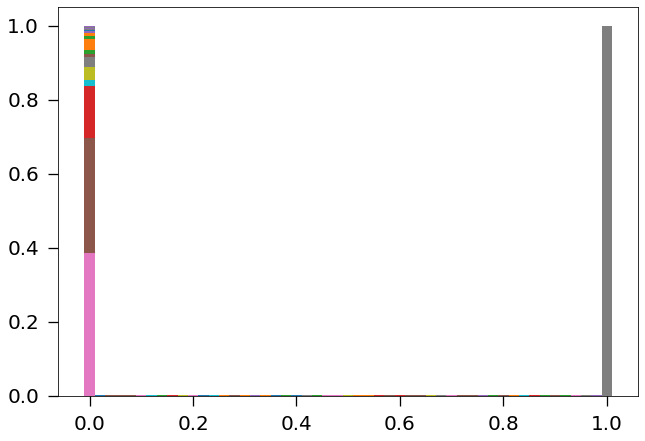

In [7]:
q=[ [0]*int(total_sample_size+1) for i in range(2*total_sample_size-1)]
afs2 = []
#a2=[]
mean_hz=[]
pooled_f=[]
for i in range(1):
    #print("iteration",i)
    ts = msprime.simulate(Ne=Deme_density, population_configurations=population_configurations, migration_matrix=matrix,record_provenance=False)
   
    a=ts.mean_descendants(leaf_list) #Finds the descendants for each trial and sums them up

    afs1 = ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False)
    
    afs2.append(afs1)
  

        
    #transition zone
    num_desc  = a.sum(axis=1)
    #print(num_desc)
    index_vals=[]
    count_vals=[]
    min_transition_zone=0 # transition frequency formula
    max_transition_zone=total_sample_size
    for j in range(len(num_desc)):
        if min_transition_zone<=num_desc[j]<=max_transition_zone:
            index_vals.append(j)
            count_vals.append(num_desc[j])
    #print(count_vals)        
    ######
    
    transition_desc=[]

    for i in range(len(index_vals)):
        transition_desc.append(a[int(index_vals[i])])
    #print(transition_desc)
    #print(len(transition_desc[0]))
    #print(len(transition_desc[1]))
    #np.savetxt("transition_zone_desc.csv", transition_desc , delimiter=",")
    
    ######
    
    spatial_transition = [ []*1 for i in range(len(transition_desc))]
    for r in range(len(transition_desc)):
        for t in range(len(transition_desc[r])):
            if transition_desc[r][t]>0:
                spatial_transition[r].append(t)


    #np.savetxt("spatial_transition.csv", spatial_transition ,fmt="%s", delimiter=",")
    
    ######
    
    demes=spatial_transition
    for i in range(len(demes)):
        for j in range(len(demes[i])):
            demes[i][j]=demes[i][j]//deme_sample_size # divides and rounds down to allocate into demes (0-1000)
  

    #np.savetxt("demes_transition.csv", demes ,fmt="%s", delimiter=",")
    
    
    ######
    
    #print(len(demes))
    freq=np.array(count_vals)
    #print(count_vals)
    #print(freq)
    freq=freq/(total_sample_size)
    
    #print("frequency")
    #print(freq)
    
    #print("count_vals")
    #print(count_vals)
    
    dist=np.linspace(0,len(demes)-1,len(demes)-1)
    #print(dist)

    #print(demes)
    #print(len(demes))
    ######
    base_width=[0]
    frequency=[0]
    demes_trans=[]
    for m in range(len(dist)):
        counter=collections.Counter(demes[int(dist[m])])
        z=list(counter.values())
        x=get_unique_numbers(demes[int(dist[m])])
        demes_trans.append(z)
        #print(z)
        #print(x)
        base_width.append(len(x)) 
        frequency.append(freq[int(dist[m])])
        #plt.bar(x,z,width=1.0)
        #lt.xlim(0,1000)
        #plt.xlabel("Deme Number")
        #plt.ylabel("Number of Descendants")
        #plt.title("Spatial distribution of branch of allele frequency " + str(freq[int(dist[i])]))
        #plt.figure()
        #plt.show()
        
  
        final_z=np.zeros(L)
        for k in range (len(final_z)):
            for l in range(len(x)):
                if k==x[l]:
                    final_z[k]=z[l]
        final_z=final_z/deme_sample_size
        (unique, counts) = np.unique(final_z, return_counts=True)
        frequencies = np.asarray((unique, counts)).T
        a,b=zip(*frequencies)
        b=np.array(b)
        b=b/L
        #plt.bar(a,b,width=1/deme_sample_size)
        weights=np.array(b)
        f=np.array(a)
        alt_f=np.array(f)
        for p in range(len(f)):
            alt_f[p]=1-f[p]
        hetero=2*f*alt_f 
        #print(hetero)
        mean_hetero=weights*hetero   
        pooled_f.append(freq[int(dist[m])])
        mean_hz.append(sum(mean_hetero))
        #plt.title("Proportion of demes with given deme allele frequency and pooled allele frequency " + str(freq[int(dist[m])]))
        #plt.xlabel("Frequency within deme")
        #plt.ylabel("Proportion of total demes")
        #plt.figure()
        #plt.show()
  


  
    

#b=np.mean(a2,0)

#b=a/trials #Divides the sum of the  descendants by the number of trials to find the expected number of descendants per node

In [8]:
np.savetxt('heterozygosity_mrho_lessthan_one.csv', mean_hz, delimiter=',')
np.savetxt('pooled_af_heteromrholess.csv', pooled_f, delimiter=',')
#print(mean_hz)
#print(pooled_f)

### Section 3: Graphs

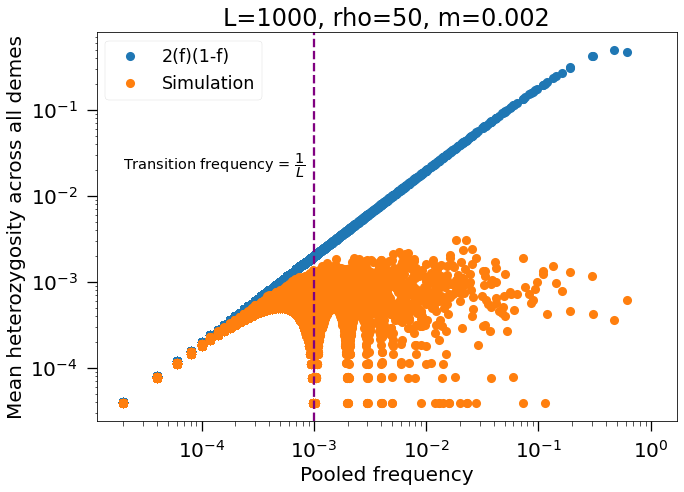

In [14]:
mean_frequency= pd.read_csv('heterozygosity_mrho_lessthan_one.csv')
p_f=pd.read_csv('pooled_af_heteromrholess.csv')
plt.loglog(p_f,2*p_f*(1-p_f),'o', label="2(f)(1-f)")
plt.loglog(p_f, mean_frequency,'o', label="Simulation")
plt.axvline(transition_freq,color='purple',linestyle = '--')
plt.xlabel('Pooled frequency')
plt.ylabel('Mean heterozygosity across all demes')
plt.text(0.00002,0.02,r"Transition frequency = $\dfrac{1}{L}$",fontsize='14.5')
plt.title('L=1000, rho=50, m=0.002')
plt.legend(prop={"size":17.5})
#plt.legend(["2*(pooled frequency)(1-pooled frequency)", "Heterozygosity of population ", 'Transition frequency'], loc ="upper left")
plt.savefig("Hetero_mrholess.pdf")